In [1]:
import os
import argparse

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

from src.model import MemNet
from src.dataset import Mnist_Mem_Dataset
from src.train import get_optimizers, train_model, test_acc

# Run Parameters

In [2]:
input_size = 784
output_size = 10
hidden_layers = [1024, 1024, 1024]
percentage_to_memorize = 0.1
batch_size = 128
epochs = 200

save_path = './models/mnist_example.ckpt'

## Dataset Defnition

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mem_dataset = Mnist_Mem_Dataset(percentage_to_memorize, device)
train_dataset =  datasets.MNIST('./data/', train=True, download=True,
                             transform = transforms.Compose([
                              transforms.ToTensor(),
                             ]))
test_dataset = datasets.MNIST('./data/', train=False, download=True,
                             transform = transforms.Compose([
                              transforms.ToTensor(),
                             ]))

In [4]:
train_laoder_cls = DataLoader(train_dataset, pin_memory=True,
                                      batch_size=batch_size, shuffle=True)

test_laoder_cls = DataLoader(test_dataset, pin_memory=True,  
                                      batch_size=batch_size, shuffle=True)

laoder_mem = DataLoader(mem_dataset,
  batch_size=batch_size, shuffle=True)

## Model Defnition

In [5]:
model = MemNet(input_size = input_size,
               output_size = output_size,
               hidden_layers = hidden_layers).to(device)

## Training

In [6]:
optimizer_mem, optimizer_cls = get_optimizers(model)

In [7]:
train_model(model, laoder_mem, train_laoder_cls,
    optimizer_mem, optimizer_cls, epochs, save_path, device)

epoch : 1/200, loss_c = 0.585784, loss_r = 0.056243
epoch : 2/200, loss_c = 0.302939, loss_r = 0.054007
epoch : 3/200, loss_c = 0.222785, loss_r = 0.052903
epoch : 4/200, loss_c = 0.178208, loss_r = 0.050758
epoch : 5/200, loss_c = 0.150847, loss_r = 0.046726
epoch : 6/200, loss_c = 0.133927, loss_r = 0.041259
epoch : 7/200, loss_c = 0.119261, loss_r = 0.035363
epoch : 8/200, loss_c = 0.108399, loss_r = 0.030044
epoch : 9/200, loss_c = 0.095081, loss_r = 0.025811
epoch : 10/200, loss_c = 0.085177, loss_r = 0.022642
epoch : 11/200, loss_c = 0.076778, loss_r = 0.020202
epoch : 12/200, loss_c = 0.070480, loss_r = 0.018419
epoch : 13/200, loss_c = 0.062088, loss_r = 0.016975
epoch : 14/200, loss_c = 0.056976, loss_r = 0.015877
epoch : 15/200, loss_c = 0.051507, loss_r = 0.015034
epoch : 16/200, loss_c = 0.045458, loss_r = 0.014307
epoch : 17/200, loss_c = 0.041948, loss_r = 0.013668
epoch : 18/200, loss_c = 0.036875, loss_r = 0.013049
epoch : 19/200, loss_c = 0.032640, loss_r = 0.012689
ep

## Test Classification

In [8]:
state = torch.load(save_path)
model.load_state_dict(state['net'])

<All keys matched successfully>

In [9]:
test_acc(model, test_laoder_cls, device)

tensor(0.9792, device='cuda:0')

## Memorized Images

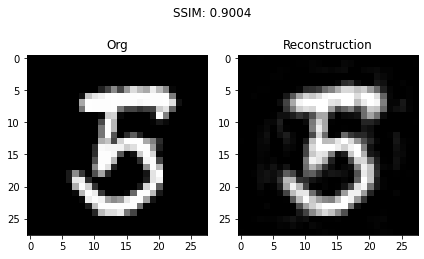

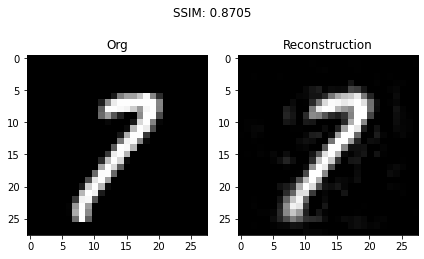

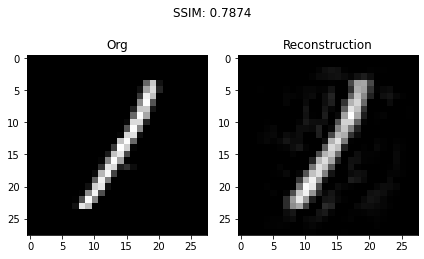

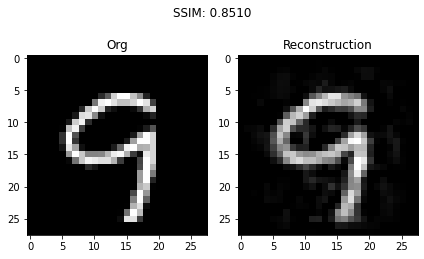

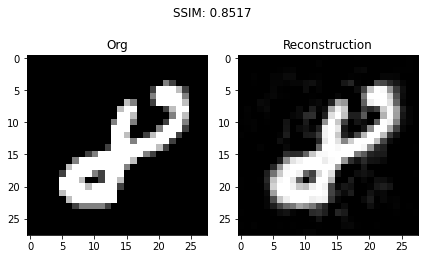

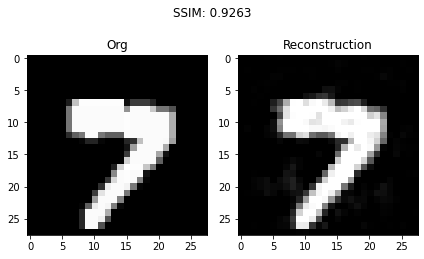

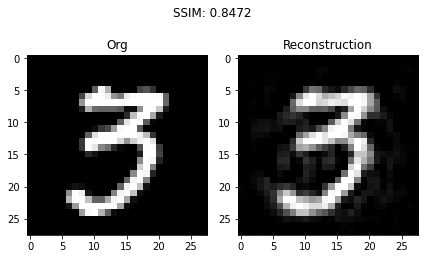

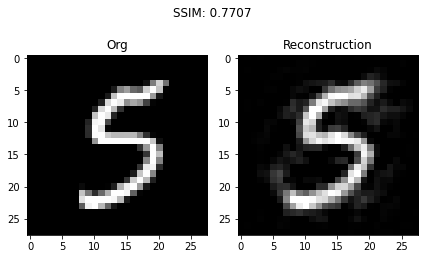

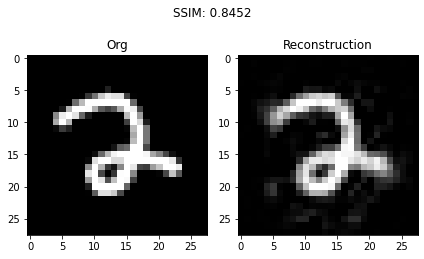

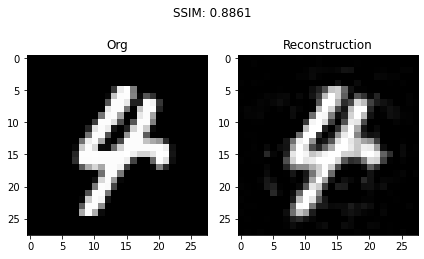

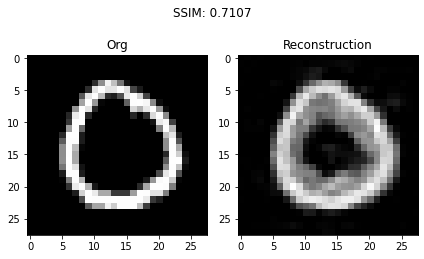

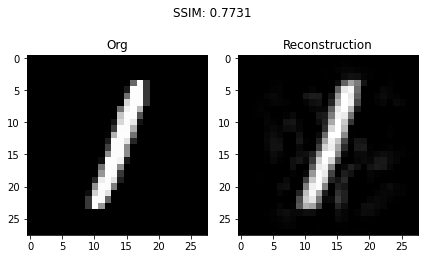

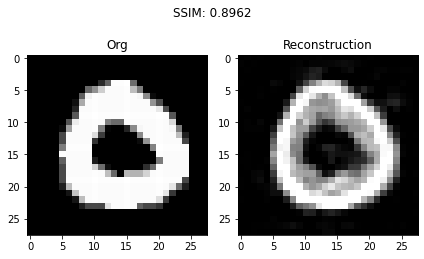

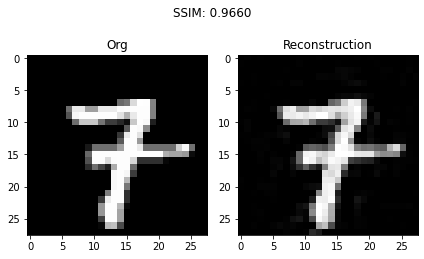

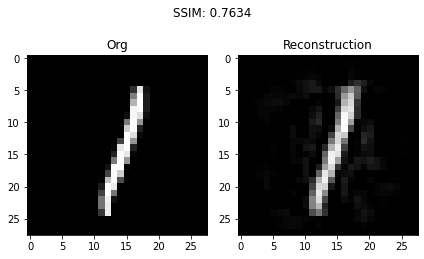

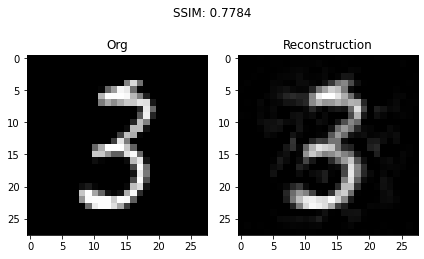

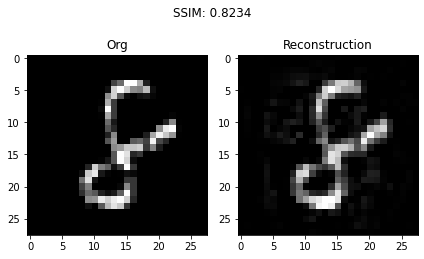

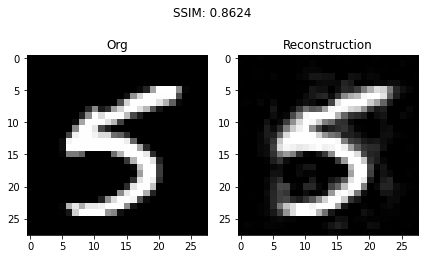

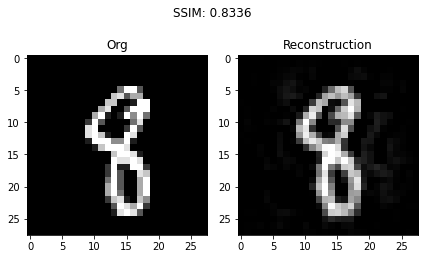

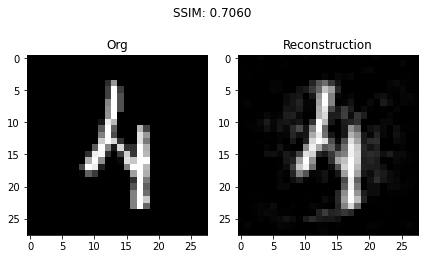

In [10]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
model.eval()
max_plot = 20
for idx, (code, _, img) in enumerate(mem_dataset):
    with torch.no_grad():
        rec_image = model.forward_transposed(code.reshape(1, 10))
        rec_image = torch.clamp(rec_image.view(28, 28), 0, 1).cpu()
        img = img.view(28, 28).cpu()
        ssim_metric = ssim(img.numpy(),
                   rec_image.numpy(),
                   multichannel=False)
        
        fig, ax = plt.subplots(ncols=2, tight_layout=True)
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Org')
        ax[1].imshow(rec_image, cmap='gray')
        ax[1].set_title('Reconstruction')
        plt.suptitle('SSIM: {:.4f}'.format(ssim_metric))
        plt.show()
        if idx == max_plot-1:
            break
        